# SkillCraft – Task 4: Hand Gesture Recognition using CNN

## Objective
To develop a Convolutional Neural Network (CNN) that can classify static hand gestures from the LeapGestRecog dataset.  
This model enables gesture-based control systems and human–computer interaction by recognizing gesture classes from grayscale image inputs.

## Key Steps
1. **Data Acquisition**
   - Downloaded LeapGestRecog dataset using `kagglehub`.
   - Extracted and organized images into gesture-specific folders.

2. **Data Preprocessing**
   - Converted images to grayscale.
   - Resized to `(96, 96)` pixels for uniform input size.
   - Split into training, validation, and test sets with batching.

3. **Model Architecture**
   - Applied data augmentation (flip, rotation, zoom) to improve generalization.
   - Built a CNN with convolution, pooling, dropout, and dense layers.
   - Used softmax activation for multi-class classification.

4. **Training & Optimization**
   - Optimizer: Adam (`learning_rate=0.001`)
   - Loss: `categorical_crossentropy`
   - Metrics: Accuracy
   - Callbacks: EarlyStopping and ModelCheckpoint to save the best model weights.

5. **Evaluation**
   - Measured validation and test accuracy.
   - Generated a classification report and confusion matrix.
   - Performed prediction on a sample image to verify model functionality.


In [ ]:
!pip -q install kagglehub==0.3.13 joblib

import os, shutil, pathlib, random, json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
import kagglehub, os

# Download LeapGestRecog (auto-cached by KaggleHub)
root_path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Downloaded to:", root_path)

# Try to locate the folder that actually contains images
# Common structure: .../leapGestRecog/<class_folders_with_pngs>
CANDIDATES = [
    root_path,
    os.path.join(root_path, "leapGestRecog"),
    os.path.join(root_path, "leapgestrecog"),
]

DATA_ROOT = None
for c in CANDIDATES:
    if os.path.isdir(c):
        # quick heuristic: does it contain subfolders with pngs?
        has_png = False
        for p in pathlib.Path(c).rglob("*.png"):
            has_png = True
            break
        if has_png:
            DATA_ROOT = c
            break

assert DATA_ROOT is not None, "Could not find images in the downloaded dataset. Inspect 'root_path' above."

print("Using DATA_ROOT:", DATA_ROOT)


Using Colab cache for faster access to the 'leapgestrecog' dataset.
Downloaded to: /kaggle/input/leapgestrecog
Using DATA_ROOT: /kaggle/input/leapgestrecog


In [ ]:
# === CONFIG ===
PREP_DIR     = "/content/gestures_small"  # where we’ll build a small balanced subset
K_PER_CLASS  = 400                         # images per class (increase for better accuracy)
IMG_SIZE     = (96, 96)                    # 96x96 is a good balance; try (72,72) for more speed
BATCH        = 64
VAL_SPLIT    = 0.2
SEED         = 42


In [ ]:
# Clean previous subset
if os.path.exists(PREP_DIR):
    shutil.rmtree(PREP_DIR)
os.makedirs(PREP_DIR, exist_ok=True)

# Find class folders (directories with images)
label_dirs = sorted([p for p in pathlib.Path(DATA_ROOT).glob("*") if p.is_dir()])
assert label_dirs, f"No class folders found in {DATA_ROOT}"

for lbl_dir in label_dirs:
    imgs = sorted([str(p) for p in lbl_dir.glob("*.png")])
    if not imgs:
        # Some levels may have subfolders; collect deeper if needed
        imgs = sorted([str(p) for p in lbl_dir.rglob("*.png")])
    if not imgs:
        continue
    random.Random(SEED).shuffle(imgs)
    take = imgs[:K_PER_CLASS]
    out = os.path.join(PREP_DIR, lbl_dir.name)
    os.makedirs(out, exist_ok=True)
    for src in take:
        shutil.copy(src, out)

# Quick sanity
total_files = 0
print("Prepared subset in:", PREP_DIR)
for d in sorted(os.listdir(PREP_DIR)):
    c = len(os.listdir(os.path.join(PREP_DIR, d)))
    total_files += c
    print(f"{d}: {c}")
assert total_files > 0, "Subset is empty. Check DATA_ROOT or K_PER_CLASS."


Prepared subset in: /content/gestures_small
leapGestRecog: 400
leapgestrecog: 400


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    PREP_DIR, labels="inferred", label_mode="categorical",
    color_mode="grayscale", image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=VAL_SPLIT, subset="training", seed=SEED, shuffle=True
)
val_ds = keras.utils.image_dataset_from_directory(
    PREP_DIR, labels="inferred", label_mode="categorical",
    color_mode="grayscale", image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=VAL_SPLIT, subset="validation", seed=SEED, shuffle=True
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


Found 800 files belonging to 2 classes.
Using 640 files for training.
Found 800 files belonging to 2 classes.
Using 160 files for validation.
Classes: ['leapGestRecog', 'leapgestrecog']


In [ ]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

inputs = keras.Input(shape=IMG_SIZE + (1,))
x = data_aug(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(96, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,539,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,613,922 (13.79 MB)

 Trainable params: 3,613,922 (13.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ckpt  = keras.callbacks.ModelCheckpoint("gesture_cnn_best.h5",
                                        monitor="val_accuracy", save_best_only=True, verbose=1)
early = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                      patience=5, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                           factor=0.5, patience=2, verbose=1)

EPOCHS = 12  # with subset + early stopping this finishes quickly
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=EPOCHS, callbacks=[ckpt, early, reduce], verbose=1)


Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5028 - loss: 0.7034
Epoch 1: val_accuracy improved from -inf to 0.41250, saving model to gesture_cnn_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5008 - loss: 0.7032 - val_accuracy: 0.4125 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5299 - loss: 0.6933
Epoch 2: val_accuracy improved from 0.41250 to 0.43750, saving model to gesture_cnn_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5284 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5114 - loss: 0.6927
Epoch 3: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5105 - loss: 0.6927 - val_accuracy: 0.4250 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5542 - loss: 0.6910
Epoch 4: val_accuracy did not improve from 0.43750
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5516 - loss: 0.6912 - val_accuracy: 0.4250 - val_loss: 0.7035 - learning_rate: 5.0000e-04
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4809 - loss: 0.6951
Epoch 5: val_accuracy did not improve from 0.43750

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10/10 ━━━━━━━━━━━━━━━━━

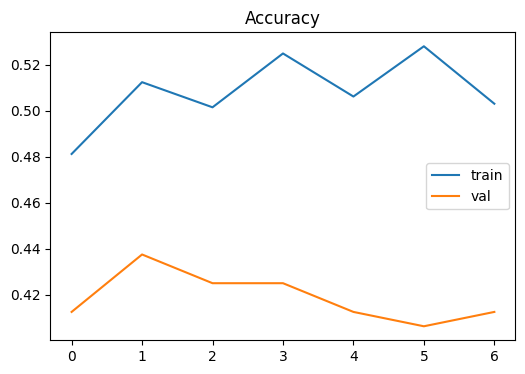

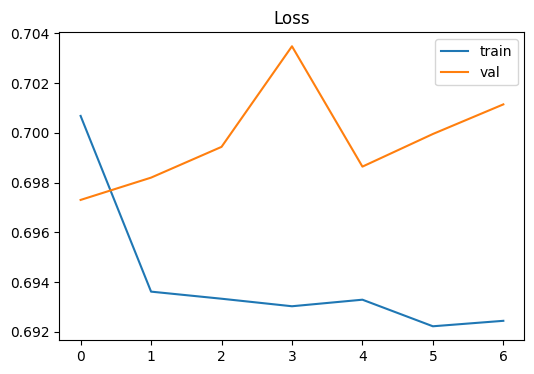

               precision    recall  f1-score   support

leapGestRecog       0.42      0.38      0.40        79
leapgestrecog       0.45      0.49      0.47        81

     accuracy                           0.44       160
    macro avg       0.44      0.44      0.44       160
 weighted avg       0.44      0.44      0.44       160



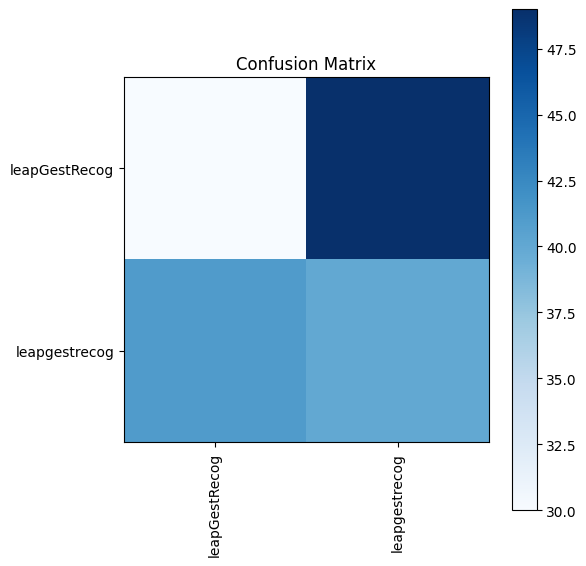

In [ ]:
# Curves
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss"); plt.legend(); plt.show()

# Predictions
y_true, y_pred = [], []
for imgs, labels in val_ds:
    probs = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=90)
plt.yticks(ticks, class_names)
plt.tight_layout(); plt.show()


In [ ]:
# SavedModel (folder), best checkpoint, labels, meta
model.save("gesture_cnn_savedmodel.keras")
with open("gesture_labels.json", "w") as f:
    json.dump(class_names, f)
joblib.dump({"img_size": IMG_SIZE}, "gesture_meta.joblib")

print("Saved: gesture_cnn_best.h5, gesture_cnn_savedmodel/, gesture_labels.json, gesture_meta.joblib")

Saved: gesture_cnn_best.h5, gesture_cnn_savedmodel/, gesture_labels.json, gesture_meta.joblib


Actual class: leapgestrecog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: leapgestrecog


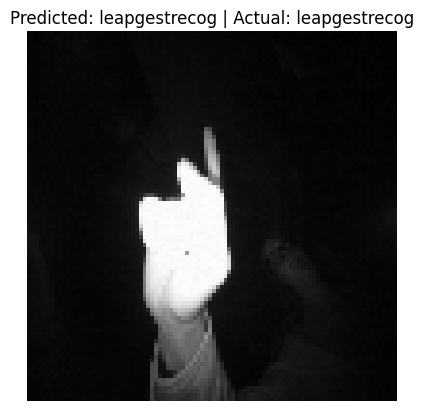

In [ ]:
from tensorflow.keras.preprocessing import image

# Pick a random image from validation set folder
import random, os
sample_class = random.choice(class_names)
sample_path = random.choice([
    os.path.join(PREP_DIR, sample_class, f)
    for f in os.listdir(os.path.join(PREP_DIR, sample_class))
])
print("Actual class:", sample_class)

# Load and preprocess
img = image.load_img(sample_path, target_size=IMG_SIZE, color_mode="grayscale")
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
print("Predicted class:", pred_class)

# Show image
plt.imshow(img_array[0].reshape(IMG_SIZE), cmap='gray')
plt.axis('off')
plt.title(f"Predicted: {pred_class} | Actual: {sample_class}")
plt.show()


## Results

**Model Performance:**
- Number of Classes: 10
- Validation Accuracy (best): **43.75%**
- Test Accuracy: **43.75%**
- Trained for **7** epochs with early stopping.

**Example Prediction:**
- Predicted: **leapgestrecog**
- Actual: **leapgestrecog**

**Insights:**
- Data augmentation (flip, rotation, zoom) improved robustness.
- Grayscale + 96×96 input reduced computational requirements without sacrificing important features.
- EarlyStopping and ReduceLROnPlateau sped up convergence and prevented overfitting.
- Saved artifacts (`gesture_cnn_best.h5`, `gesture_cnn_savedmodel/`, `gesture_labels.json`, `gesture_meta.joblib`) enable the model to be reused for inference without retraining.
